In [1]:
# Now to check out how we can run a survey that uses a Markov Decision Process to generate pointings

In [2]:
from rubin_sim.scheduler.utils import Sky_area_generator
import healpy as hp
%matplotlib inline
import numpy as np

In [3]:
sag = Sky_area_generator()
sky_maps, labels = sag.return_maps()

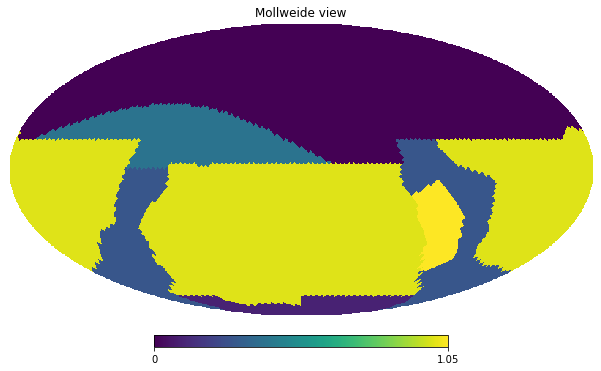

In [4]:
hp.mollview(sky_maps['r'])

0 
1 LMC_SMC
2 bulge
3 dusty_plane
4 lowdust
5 nes
6 scp
7 virgo


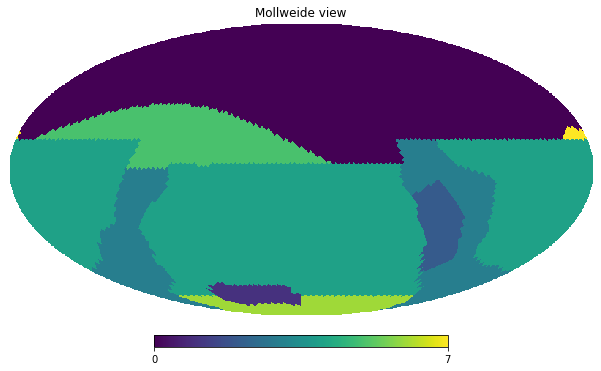

In [5]:
# Look at the labels
label_int = np.zeros(hp.nside2npix(32))
for i,label in enumerate(np.unique(labels)):
    indx = np.where(labels == label)[0]
    label_int[indx] = i
    print(i, label)
hp.mollview(label_int)
